In [1]:
import numpy as np
#import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('ggplot')
%matplotlib inline

from sklearn import cluster, feature_extraction, decomposition, manifold, metrics, datasets
from scipy.spatial import distance

from gensim import corpora, models, matutils
from gensim.parsing.preprocessing import STOPWORDS

from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

## Data loading

In [2]:
categories=['comp.sys.mac.hardware', 'soc.religion.christian', 'rec.sport.hockey', 'sci.med', 'sci.space']

dataset = datasets.fetch_20newsgroups(subset='train', categories=categories)
n_topics = len(categories)

In [3]:
X = dataset.data[0:1000]
y = dataset.target[0:1000]

## Feature extraction

In [4]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_df=500, min_df=10, stop_words='english')
matrix = vectorizer.fit_transform(X)
matrix.shape

(1000, 2358)

## Distance Matrix
**Cosine metric** is a popular choice for computing the similarity of documents represented as tf-idf vectors.

In [5]:
# condensed(triangular) distance matrix
cos = distance.pdist(matrix.toarray(), metric='cosine') 
# converts from condensed distance matrix to square distance matrices
cos = distance.squareform(cos)

## Clusters number defining

In [6]:
np.random.seed(234)
n = matrix.shape[0] # sample size
K = range(2, 11)

silhouette_avg = []
inertia = []

for k in K:
    kmeans = cluster.MiniBatchKMeans(n_clusters=k).fit(matrix)
    silhouette_avg.append(metrics.silhouette_score(cos, kmeans.labels_, metric="precomputed"))
    inertia.append(kmeans.inertia_)

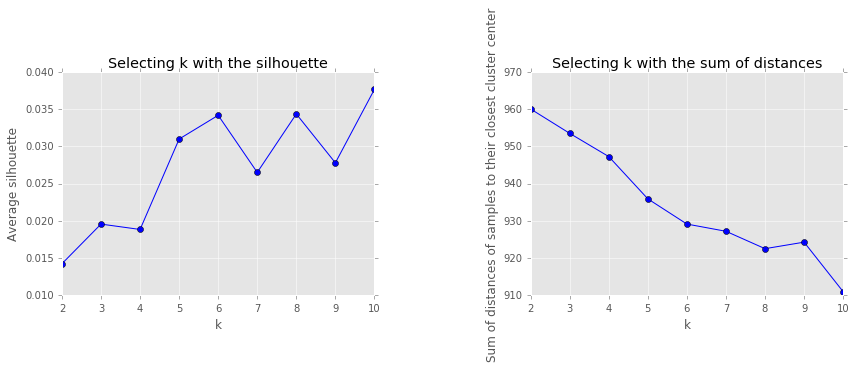

In [7]:
plt.figure(figsize=(14,4))
plt.subplots_adjust(hspace=0.2, wspace=0.5)

plt.subplot(121)
plt.plot(K, silhouette_avg, 'bo-')
plt.xlabel('k')
plt.ylabel('Average silhouette')
plt.title('Selecting k with the silhouette')
plt.grid(True)

plt.subplot(122)
plt.plot(K, inertia, 'bo-')
plt.xlabel('k')
plt.ylabel('Sum of distances of samples to their closest cluster center')
plt.title('Selecting k with the sum of distances')
plt.grid(True)

plt.show()

In [8]:
n = matrix.shape[0] # sample size
K = range(2, 11)

silhouette_avg = []

for k in K:
    kmeans = cluster.hierarchical.AgglomerativeClustering(n_clusters=k,affinity='precomputed', linkage='complete').fit(cos)
    silhouette_avg.append(metrics.silhouette_score(cos, kmeans.labels_, metric="precomputed"))


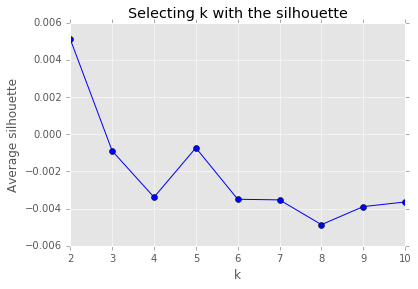

In [9]:
plt.subplot(111)
plt.plot(K, silhouette_avg, 'bo-')
plt.xlabel('k')
plt.ylabel('Average silhouette')
plt.title('Selecting k with the silhouette')
plt.grid(True)

В случае кластеризации текста (тематическое моделирование), или поиска сообществ в социальном графе, выборка имеет ряд отличительных причин:
- высокоразмерное признаковое пространство
- разреженные данные
- данные распределены по степенному закону

В таком случае методы определения числа кластеров (silhouette measure, Elbow method) не работают.

## Feature space decomposition and visualization
To define clustering structure it is useful to visualize it into 2D or 3D space

### linear method

#### PCA

In [10]:
# TruncatedSVD is very similar to PCA, but differs in that it works on sample matrices X 
# directly instead of their covariance matrices.

svd2d = decomposition.TruncatedSVD(n_components=2, algorithm='randomized', n_iter=5, random_state=0)
data_svd2d = svd2d.fit_transform(matrix.toarray())

In [11]:
svd3d = decomposition.TruncatedSVD(n_components=3, algorithm='randomized', n_iter=5, random_state=0)
data_svd3d = svd3d.fit_transform(matrix.toarray())

In [12]:
def renderClusters(data2d, data3d):
    fig = plt.figure(figsize=(14,6))

    ax1 = fig.add_subplot(121)
    ax1.scatter(data2d[:, 0], data2d[:, 1], c = y)

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(data3d[:, 0], data3d[:, 1], data3d[:, 2],c = y, zdir='z')

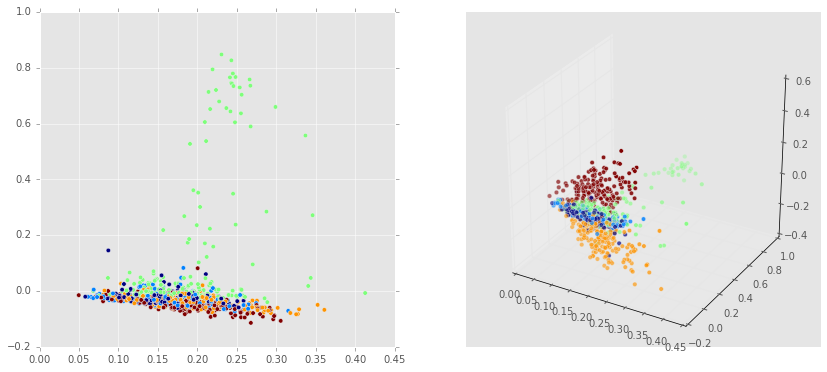

In [13]:
renderClusters(data_svd2d, data_svd3d)

### Non-linear methods

#### Isomap

In [14]:
isomap2d = manifold.Isomap(n_neighbors=15, n_components=2)
data_isomap2d = isomap2d.fit_transform(matrix.toarray())

In [15]:
isomap3d = manifold.Isomap(n_neighbors=15, n_components=3)
data_isomap3d = isomap3d.fit_transform(matrix.toarray())

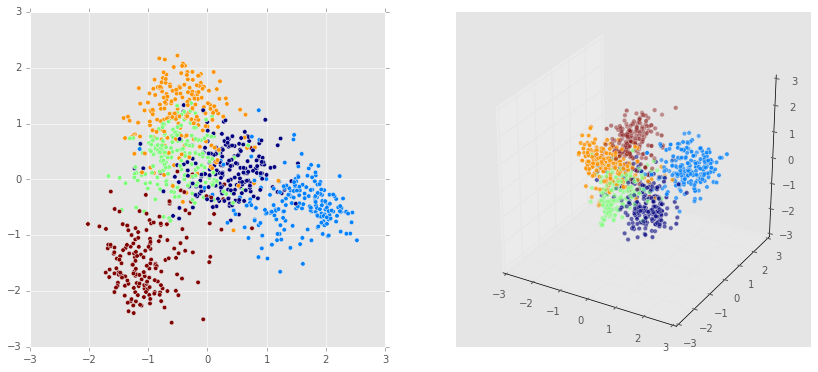

In [16]:
renderClusters(data_isomap2d, data_isomap3d)

#### MDS

In [17]:
mds2d = manifold.MDS(n_components=2, metric=True, n_init=4, max_iter=300, dissimilarity='precomputed')
data_mds2d = mds2d.fit_transform(cos)

In [18]:
mds3d = manifold.MDS(n_components=3, metric=True, n_init=4, max_iter=300, dissimilarity='precomputed')
data_mds3d = mds3d.fit_transform(cos)

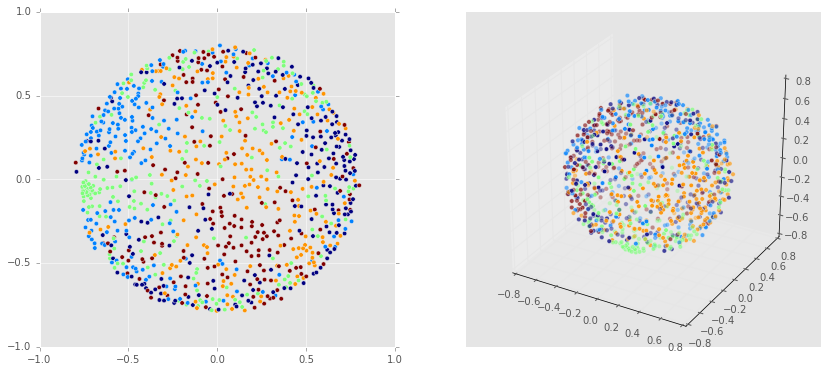

In [19]:
renderClusters(data_mds2d, data_mds3d)

#### t-SNE

In [20]:
tsne2d = manifold.TSNE(n_components=2, metric='precomputed', init='random', random_state=0)
data_tsne2d = tsne2d.fit_transform(cos)

In [21]:
tsne3d = manifold.TSNE(n_components=3, metric='precomputed', init='random', random_state=0)
data_tsne3d = tsne3d.fit_transform(cos)

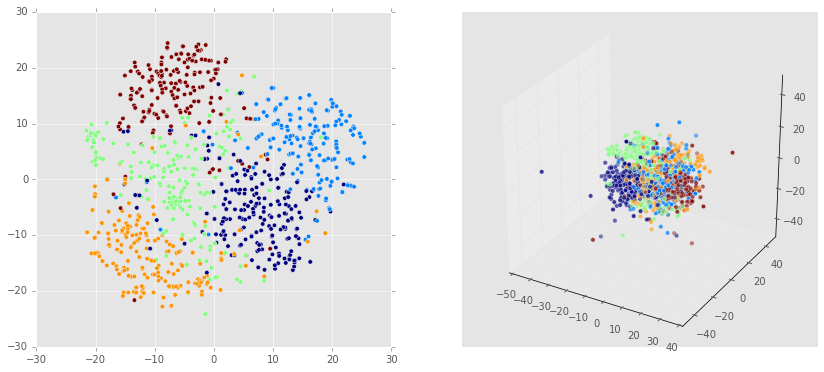

In [22]:
renderClusters(data_tsne2d, data_tsne3d)

## Clustering

### kmeans

In [23]:
np.random.seed(234)
kmeans = cluster.MiniBatchKMeans(n_clusters=n_topics).fit(matrix.toarray())
preds = kmeans.predict(matrix.toarray())

In [24]:
import itertools
def getMappedPreds(preds, target):
    # target labels
    labels = range(len(set(target)))
    
    # all possible permutations of lzbels
    permutations = itertools.permutations(labels)
    
    error_percent = []
    for i in permutations:
        mapping = dict(zip([j for j in i], labels))
        
        mapped_preds = [mapping[pred] for pred in preds]
        
        # tuple (error_percent, mapping)
        error_percent.append((float(sum(mapped_preds != target)) / len(target), mapping))
        
    mapping = error_percent[np.argmin([i[0] for i in error_percent])][1]
    
    return [mapping[pred] for pred in preds]

In [25]:
def drawLabelDistribution(preds, target):    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,4))
    f.subplots_adjust(hspace=0.2, wspace=0.5)
    f.suptitle('Distribution by classes', fontsize=16, y=1.05)

    ax1.set_title('Predictions')
    ax1.set_xlabel('predicted classes')
    ax1.set_ylabel('Count')
    ax1.hist(preds)


    ax2.set_title('True labels')
    ax2.set_xlabel('predicted classes')
    ax2.hist(target)

    plt.show()

In [26]:
mapped_preds = getMappedPreds(preds, y)
err_kmeans = float(sum(mapped_preds != y)) / len(y)
print 'Error fraction:', err_kmeans

Error fraction: 0.33


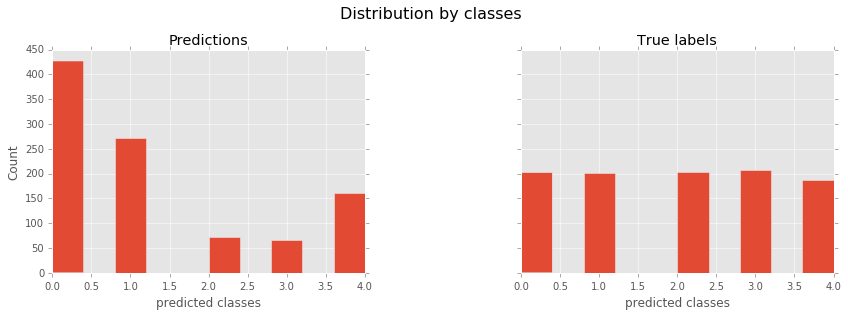

In [27]:
drawLabelDistribution(mapped_preds, y)

In [28]:
print (metrics.classification_report(y, mapped_preds))

             precision    recall  f1-score   support

          0       0.44      0.94      0.60       202
          1       0.70      0.95      0.81       201
          2       0.95      0.34      0.50       203
          3       0.90      0.29      0.44       207
          4       0.99      0.86      0.92       187

avg / total       0.79      0.67      0.65      1000



In [29]:
print (metrics.confusion_matrix(y, mapped_preds))

[[190   6   3   2   1]
 [ 10 191   0   0   0]
 [ 61  68  69   5   0]
 [141   5   1  60   0]
 [ 25   2   0   0 160]]


### agglomerative clustering

In [30]:
hier = cluster.hierarchical.AgglomerativeClustering(n_clusters=n_topics, affinity='precomputed', linkage='complete')

In [31]:
preds = hier.fit_predict(cos)

In [32]:
mapped_preds = getMappedPreds(preds, y)
err_aggl = float(sum(mapped_preds != y)) / len(y)
print 'Error fraction:', err_aggl 

Error fraction: 0.725


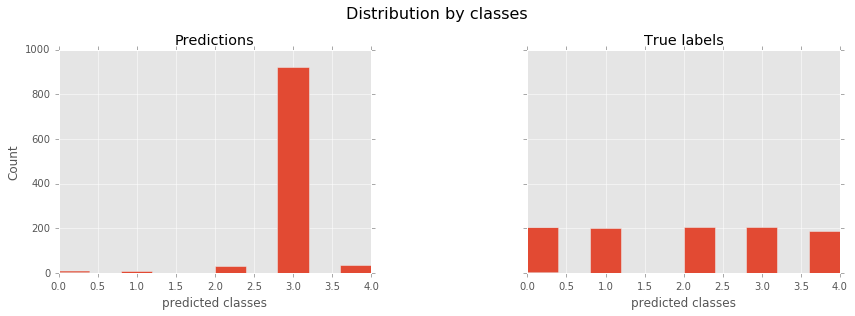

In [33]:
drawLabelDistribution(mapped_preds, y)

In [34]:
print (metrics.classification_report(y, mapped_preds))
print (metrics.confusion_matrix(y, mapped_preds))

             precision    recall  f1-score   support

          0       1.00      0.04      0.08       202
          1       0.00      0.00      0.00       201
          2       0.93      0.13      0.23       203
          3       0.22      1.00      0.36       207
          4       1.00      0.18      0.31       187

avg / total       0.62      0.28      0.20      1000

[[  8   7   1 186   0]
 [  0   0   0 201   0]
 [  0   0  27 176   0]
 [  0   0   1 206   0]
 [  0   0   0 153  34]]


### clustering with decomposition

#### SVD + kmeans

In [35]:
np.random.seed(234)
svd = decomposition.TruncatedSVD(n_components=matrix.toarray().shape[1]/3)
features = svd.fit_transform(matrix.toarray())

In [36]:
np.random.seed(234)
kmeans = cluster.MiniBatchKMeans(n_clusters=n_topics)
preds = kmeans.fit_predict(features)

mapped_preds = getMappedPreds(preds, y)
err_svdkmeans = float(sum(mapped_preds != y)) / len(y)
print 'Error fraction:', err_svdkmeans

Error fraction: 0.385


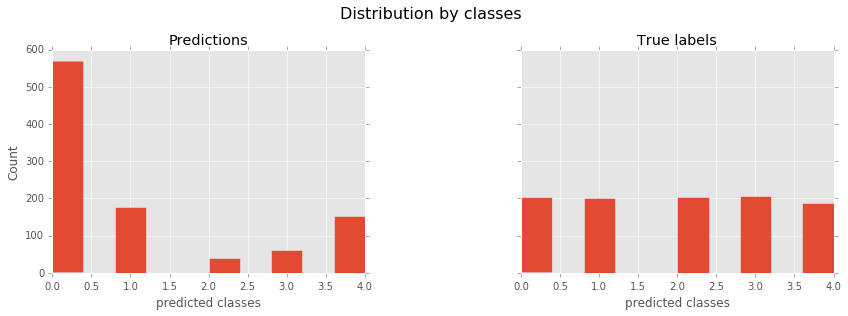

In [37]:
drawLabelDistribution(mapped_preds, y)

In [38]:
print (metrics.classification_report(y, mapped_preds))
print (metrics.confusion_matrix(y, mapped_preds))

             precision    recall  f1-score   support

          0       0.34      0.97      0.51       202
          1       0.99      0.88      0.93       201
          2       0.85      0.16      0.27       203
          3       0.93      0.28      0.43       207
          4       0.99      0.81      0.89       187

avg / total       0.82      0.61      0.60      1000

[[196   1   3   1   1]
 [ 24 177   0   0   0]
 [167   0  33   3   0]
 [148   0   2  57   0]
 [ 34   0   1   0 152]]


#### SVD + Agglomerative

In [39]:
hier = cluster.hierarchical.AgglomerativeClustering(n_clusters=n_topics, affinity='cosine', linkage='complete')
preds = hier.fit_predict(features)

mapped_preds = getMappedPreds(preds, y)
err_svdaggl = float(sum(mapped_preds != y)) / len(y)
print 'Error fraction:', err_svdaggl

Error fraction: 0.69


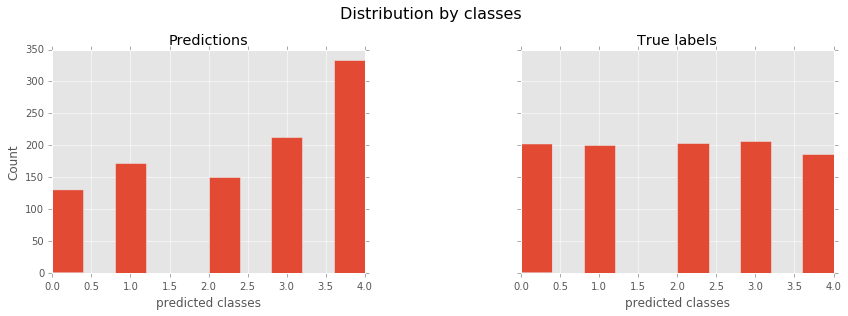

In [40]:
drawLabelDistribution(mapped_preds, y)

In [41]:
print (metrics.classification_report(y, mapped_preds))
print (metrics.confusion_matrix(y, mapped_preds))

             precision    recall  f1-score   support

          0       0.37      0.24      0.29       202
          1       0.26      0.22      0.24       201
          2       0.40      0.30      0.34       203
          3       0.31      0.32      0.32       207
          4       0.27      0.48      0.34       187

avg / total       0.32      0.31      0.31      1000

[[48 39 22 21 72]
 [52 45 30 17 57]
 [ 5 23 61 55 59]
 [16 45 22 67 57]
 [ 9 20 16 53 89]]


### LDA

In [42]:
corpus = matutils.Sparse2Corpus(matrix, documents_columns=False)

In [43]:
np.random.seed(43)
lda = models.ldamodel.LdaModel(corpus, num_topics=n_topics)

In [44]:
corpus_lda = lda[corpus]

In [45]:
preds = np.array([np.argmax([j[1] for j in i], axis=0) for i in corpus_lda])
mapped_preds = getMappedPreds(preds, y)
err_lda = float(sum(mapped_preds != y)) / len(y)
print 'Error fraction:', err_lda

Error fraction: 0.745


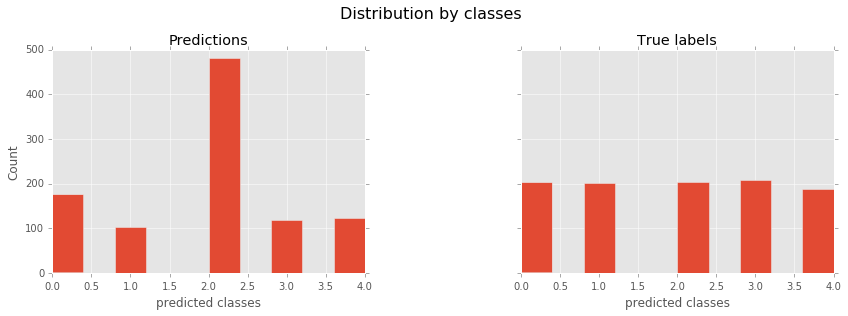

In [46]:
drawLabelDistribution(mapped_preds, y)

In [47]:
print (metrics.classification_report(y, mapped_preds))
print (metrics.confusion_matrix(y, mapped_preds))

             precision    recall  f1-score   support

          0       0.29      0.25      0.27       202
          1       0.34      0.17      0.23       201
          2       0.22      0.52      0.31       203
          3       0.31      0.18      0.23       207
          4       0.22      0.14      0.17       187

avg / total       0.28      0.26      0.24      1000

[[ 50  19  92  20  21]
 [ 27  35  68  41  30]
 [ 48  22 106   8  19]
 [ 21  14 109  37  26]
 [ 29  13 106  12  27]]


### LSI

In [48]:
np.random.seed(43)
lsi = models.LsiModel(corpus, num_topics=n_topics)

In [49]:
corpus_lsi = lsi[corpus]

In [50]:
preds = np.array([np.argmax([j[1] for j in i], axis=0) for i in corpus_lsi])
mapped_preds = getMappedPreds(preds, y)
err_lsi = float(sum(mapped_preds != y)) / len(y)
print 'Error fraction:', err_lsi

Error fraction: 0.606


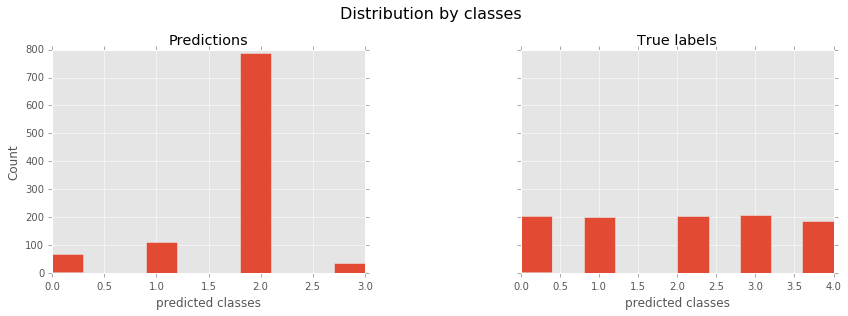

In [51]:
drawLabelDistribution(mapped_preds, y)

In [53]:
print (metrics.classification_report(y, mapped_preds))
print (metrics.confusion_matrix(y, mapped_preds))

             precision    recall  f1-score   support

          0       0.85      0.28      0.42       202
          1       1.00      0.55      0.71       201
          2       0.25      0.95      0.39       203
          3       0.94      0.16      0.28       207
          4       0.00      0.00      0.00       187

avg / total       0.62      0.39      0.36      1000

[[ 56   0 145   1   0]
 [  0 111  90   0   0]
 [  9   0 193   1   0]
 [  1   0 172  34   0]
 [  0   0 187   0   0]]


### Preprocessing using nltk

In [54]:
# word frequency thresholds
max_df=500 
min_df=10

In [55]:
from collections import defaultdict
frequency = defaultdict(int)

tokenizer = RegexpTokenizer(r'\w+')
p_stemmer = PorterStemmer()
# list for tokenized documents in loop
texts = []

# loop through document list
for i in X:
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)
    
    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in STOPWORDS]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # frequency counting
    for token in i:
        frequency[token] += 1
        
    # add tokens to list
    texts.append(stemmed_tokens)

# filtering by frequency
texts = [[token for token in text if (frequency[token] >= min_df) | (frequency[token] <= max_df)]
         for text in texts]

dictionary = corpora.Dictionary(texts)

#bad_ids = [tokenid for tokenid, docfreq in dictionary.dfs.iteritems() if docfreq <= min_df | docfreq >= max_df]

#dictionary.filter_tokens(bad_ids=bad_ids, good_ids=None)
#dictionary.compactify() 

print (dictionary)

Dictionary(19660 unique tokens: [u'circuitri', u'phobo', u'foul', u'interchang', u'elvi']...)


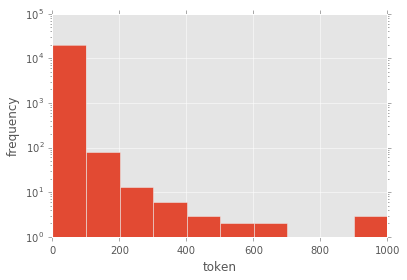

In [56]:
plt.hist(dictionary.dfs.values(), log=True)
plt.xlabel('token')
plt.ylabel('frequency')
plt.show()

In [57]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [58]:
tfidf = models.TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]

In [59]:
np.random.seed(43)
lda = models.ldamodel.LdaModel(corpus_tfidf, num_topics=n_topics, id2word = dictionary, passes=5)
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=n_topics)

In [60]:
corpus_lda = lda[corpus_tfidf]
corpus_lsi = lsi[corpus_tfidf]

In [61]:
preds = np.array([np.argmax([j[1] for j in i], axis=0) for i in corpus_lda])
mapped_preds = getMappedPreds(preds, y)
err_ldanltk = float(sum(mapped_preds != y)) / len(y)
print 'Error fraction:', err_ldanltk

Error fraction: 0.737


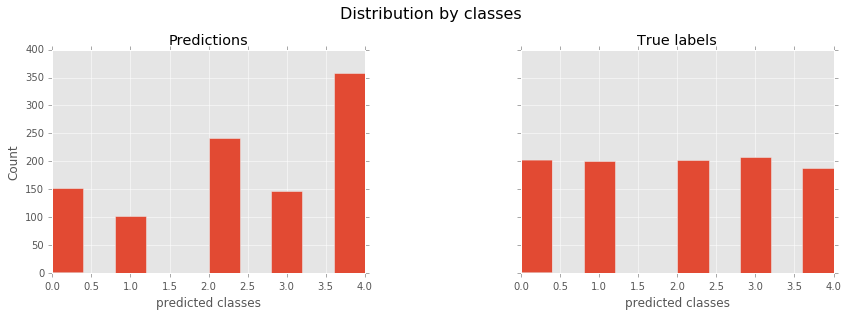

In [62]:
drawLabelDistribution(mapped_preds, y)

In [63]:
print (metrics.classification_report(y, mapped_preds))
print (metrics.confusion_matrix(y, mapped_preds))

             precision    recall  f1-score   support

          0       0.31      0.23      0.27       202
          1       0.34      0.17      0.23       201
          2       0.24      0.29      0.26       203
          3       0.27      0.19      0.22       207
          4       0.23      0.45      0.31       187

avg / total       0.28      0.26      0.26      1000

[[47 30 31 32 62]
 [35 35 32 21 78]
 [27 18 58 27 73]
 [31 15 61 39 61]
 [11  4 60 28 84]]


In [64]:
preds = np.array([np.argmax([j[1] for j in i], axis=0) for i in corpus_lsi])
mapped_preds = getMappedPreds(preds, y)
err_lsinltk = float(sum(mapped_preds != y)) / len(y)
print 'Error fraction:', err_lsinltk

Error fraction: 0.691


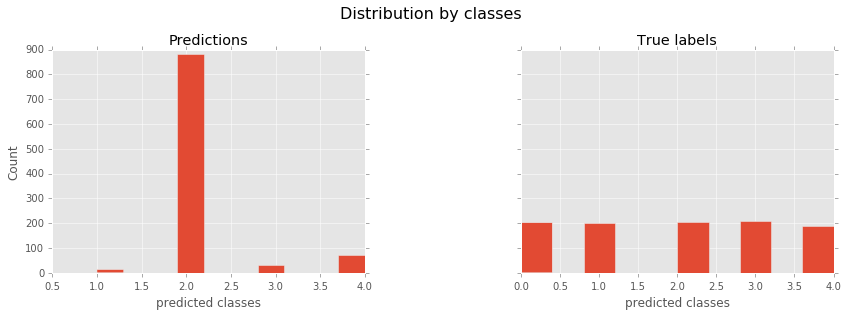

In [65]:
drawLabelDistribution(mapped_preds, y)

In [66]:
print (metrics.classification_report(y, mapped_preds))
print (metrics.confusion_matrix(y, mapped_preds))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       202
          1       0.08      0.00      0.01       201
          2       0.23      1.00      0.37       203
          3       1.00      0.16      0.27       207
          4       1.00      0.39      0.56       187

avg / total       0.46      0.31      0.24      1000

[[  0   1 201   0   0]
 [  0   1 200   0   0]
 [  0   0 203   0   0]
 [  0   9 165  33   0]
 [  0   2 113   0  72]]


## Comparising clustering methods performance

<Container object of 8 artists>

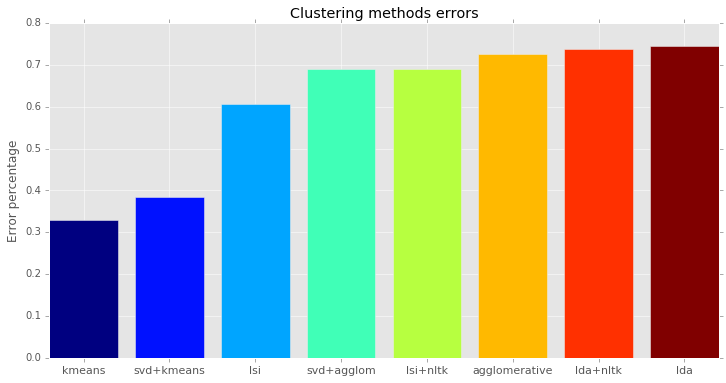

In [67]:
# sorting errorrs percentage by value 
d = sorted(zip([err_kmeans, err_aggl, err_svdkmeans, err_svdaggl, err_lda, err_lsi, err_ldanltk, err_lsinltk],
               ['kmeans', 'agglomerative', 'svd+kmeans', 'svd+agglom', 'lda', 'lsi', 'lda+nltk', 'lsi+nltk']))

errors = [i[0] for i in d]
xlabels = [i[1] for i in d]

ticks = range(len(errors))

colors = plt.cm.jet(np.linspace(0,1, len(errors)))

plt.figure(figsize=(12,6))
plt.xticks(ticks, xlabels, size=11)
plt.title('Clustering methods errors')
plt.ylabel('Error percentage')
plt.bar(ticks, errors, align='center',color=colors)